In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'

from transformers import AutoTokenizer, AutoConfig, MistralForCausalLM
from ebany_research.llm_lora.changed_mistral import ChangedMistralForCausalLM
from datasets import load_dataset
import torch


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model_name = "Open-Orca/Mistral-7B-OpenOrca"
# model_name = "ebany_research/llm_lora/train_results"
config = AutoConfig.from_pretrained(model_name)
device = 3
model = MistralForCausalLM.from_pretrained(model_name, device_map={"": device})
model = model.eval()
# 29410MiB
model = model.half()
print(count_parameters(model))
# model = MistralForCausalLM.from_pretrained(
#     model_name,
# )
# model = MistralForCausalLM._from_config(config=config)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
dataset = load_dataset("openaccess-ai-collective/oo-gpt4-filtered")
dataset = dataset["train"].to_list()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:36<00:00, 18.03s/it]


7241748480


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/user-name-goes-here/.local/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [7]:
from transformers import AutoTokenizer, AutoConfig

config = AutoConfig.from_pretrained("Open-Orca/Mistral-7B-OpenOrca")
config.lora_layers = [1, 2, 3, 4]
config

MistralConfig {
  "_name_or_path": "Open-Orca/Mistral-7B-OpenOrca",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "lora_layers": [
    1,
    2,
    3,
    4
  ],
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.1",
  "use_cache": true,
  "vocab_size": 32002
}

In [7]:
dataset[0].keys()

dict_keys(['id', 'system_prompt', 'question', 'response', '__index_level_0__'])

In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding, DataCollatorForLanguageModeling


class OpenOrcaDataset(Dataset):
    def __init__(
        self,
        dataset=None,
        tokenizer=None,
    ):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        dataset_item = self.dataset[idx]
        chat = [
            {"role": "system", "content": dataset_item["system_prompt"]},
            {"role": "user", "content": dataset_item["question"]},
            {"role": "assistant", "content": dataset_item["response"]},
        ]
        inputs = self.tokenizer.apply_chat_template(
            chat,
            tokenize=False,
            add_generation_prompt=True,
        )
        inputs = self.tokenizer(
            inputs,
            return_tensors="pt",
        )
        for key in inputs.keys():
            inputs[key] = inputs[key].squeeze(0)
        # print(inputs['input_ids'].shape)
        return inputs


train_elements = 1000
valid_elements = 100

train_dataset = OpenOrcaDataset(
    dataset=dataset[:train_elements],
    tokenizer=tokenizer,
)

valid_dataset = OpenOrcaDataset(
    dataset=dataset[train_elements : train_elements + valid_elements],
    tokenizer=tokenizer,
)

pad_datacollator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    # padding=True,
    mlm=False,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=2,
    collate_fn=pad_datacollator,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=2,
    collate_fn=pad_datacollator,
)

next(iter(train_dataloader))
next(iter(valid_dataloader))
# train_dataset[0]

{'input_ids': tensor([[    1, 32001,  1587,    13,  1976,   460,   396, 16107, 13892, 28723,
           995,   622,   347,  2078,   264,  3638, 28723,   995,  1580,  8270,
           264, 10537,   304,  1043,  4372, 28723, 32000, 32001,  2188,    13,
            13,    13, 28798,   556,   276,  1987, 11285, 28742, 28713,  3487,
         20415,   298,  1912,   706,   684,   272,  6400,   354,   272,  8982,
          4150, 28723, 28705, 12628,   272,  2996,   345, 11273,   400,  1987,
           767,   863, 14151,   927,   298,   511, 28804,   548,   349,   345,
         10847,   264,  4150, 28739,   264,  3716,  4372, 28804,    13,  2820,
         16981, 28747, 32000, 32001, 13892,    13,  2501, 28725,   345, 10847,
           264,  4150, 28739,   349,   459,   264,  3716,  4372,   298,   272,
          2996,   345, 11273,   400,  1987,   767,   863, 14151,   927,   298,
           511,  1110, 28723,   415,  2996, 21165,   356,   767, 14151,  3236,
           298,   511,  1159,  2492,  

### student model

In [2]:
device = 0
student_model = MistralForCausalLM.from_pretrained(model_name, device_map={"": device})
student_model = student_model.eval()
student_model = student_model.half()

Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.94s/it]


In [3]:
distill_layer = 17
student_mlp = student_model.model.layers[distill_layer].mlp

student_gate_proj = student_mlp.gate_proj.weight.data
student_up_proj = student_mlp.up_proj.weight.data
student_down_proj = student_mlp.down_proj.weight.data

In [6]:
import numpy as np

# np.linalg.matrix_rank(student_gate_proj.to(torch.float32).cpu().numpy())
# np.linalg.matrix_rank(student_up_proj.to(torch.float32).cpu().numpy())
np.linalg.matrix_rank(student_down_proj.to(torch.float32).cpu().numpy())

4096

In [9]:
64 * 64

4096

In [ ]:
student_gate_proj.shape,

In [10]:
from scipy.sparse.linalg import svds

student_gate_proj_num = student_gate_proj.to(torch.float32).cpu().numpy()
us, ss, vTs = svds(student_gate_proj_num, k=512)

In [11]:
us.shape, ss.shape, vTs.shape

((14336, 512), (512,), (512, 4096))

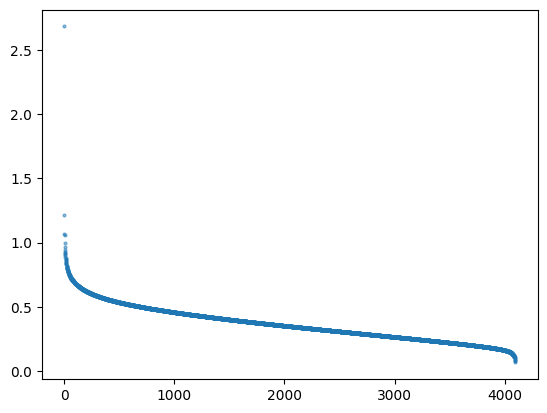

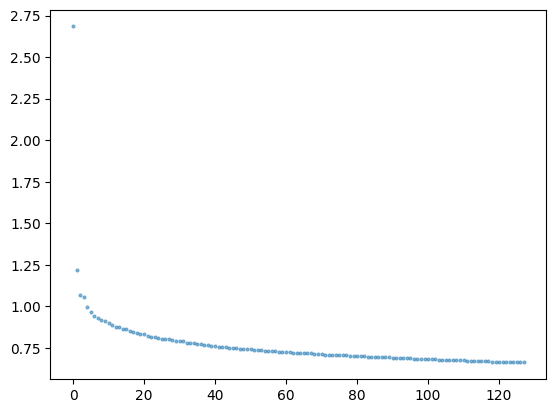

In [12]:
import matplotlib.pyplot as plt
import numpy as np

U, S, Vh = torch.linalg.svd(
    student_gate_proj.to(torch.float32),
    # student_up_proj.to(torch.float32),
    # student_down_proj.to(torch.float32),
    # student_model.model.embed_tokens.weight.data.to(torch.float32),
    full_matrices=False,
)


area = 4

plt.scatter(
    torch.arange(0, S.shape[0]).numpy(),
    S.cpu().numpy(),
    s=area,
    alpha=0.5,
)
plt.show()

threshold = 128
plt.scatter(
    torch.arange(0, threshold).numpy(),
    S[:threshold].cpu().numpy(),
    s=area,
    alpha=0.5,
)
plt.show()

In [13]:
U.shape, S.shape, Vh.shape

(torch.Size([14336, 4096]), torch.Size([4096]), torch.Size([4096, 4096]))

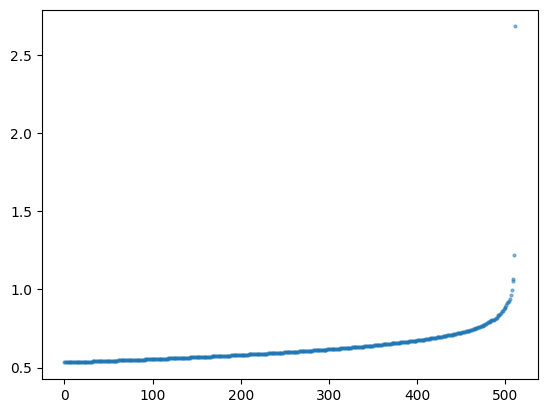

In [15]:
plt.scatter(
    torch.arange(0, ss.shape[0]).numpy(),
    ss.T,
    s=area,
    alpha=0.5,
)
plt.show()

в целом можно заметить что самые основные значения лежат на первых 8-16

In [68]:
student_model.model.embed_tokens.weight.data.shape

torch.Size([32002, 4096])

In [69]:
32002 * 4096

131080192

### Replace to lora

In [6]:
(U @ torch.diag(S) @ Vh).shape

torch.Size([14336, 4096])

In [6]:
# from ebany_research.llm_lora.changed_neox import LinearLora
def get_L_R(weights=None, rank=64):
    U, S, Vh = torch.linalg.svd(
        weights.to(torch.float32),
        full_matrices=False,
    )

    U = U[:, :rank]
    S = torch.diag(S[:rank])
    Vh = Vh[:rank, :]

    L = U @ S
    R = Vh
    return L, R


L, R = get_L_R(student_down_proj)
print(L.shape, R.shape)


class LinearLora(torch.nn.Module):
    def __init__(self, in_dim=768, out_dim=768, r=16, bias=False):
        super().__init__()
        self.L = torch.nn.Linear(in_dim, r, bias=bias)
        self.R = torch.nn.Linear(r, out_dim, bias=bias)

    def forward(self, hidden_states):
        hidden_states = self.R(hidden_states)
        hidden_states = self.L(hidden_states)
        return hidden_states


def assign_new_weights(original_module, original_weights):
    L, R = get_L_R(original_weights, rank=16)
    original_module.L.weight.data = L
    original_module.R.weight.data = R


lora_gate_proj = LinearLora(
    in_dim=config.hidden_size,
    out_dim=config.intermediate_size,
    bias=False,
)
lora_up_proj = LinearLora(
    in_dim=config.hidden_size,
    out_dim=config.intermediate_size,
    bias=False,
)
lora_down_proj = LinearLora(
    in_dim=config.intermediate_size,
    out_dim=config.hidden_size,
    bias=False,
)

assign_new_weights(
    original_module=lora_gate_proj,
    original_weights=student_gate_proj,
)
assign_new_weights(
    original_module=lora_up_proj,
    original_weights=student_up_proj,
)
assign_new_weights(
    original_module=lora_down_proj,
    original_weights=student_down_proj,
)

student_mlp.gate_proj = lora_gate_proj
student_mlp.up_proj = lora_up_proj
student_mlp.down_proj = lora_down_proj

torch.Size([4096, 64]) torch.Size([64, 14336])


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(count_parameters(model))
print(count_parameters(student_model))

7241748480
7066472448


### eval original model

In [7]:
import tqdm


def eval_model(model):
    total_eval_loss = 0
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            for eval_batch in tqdm.tqdm(valid_dataloader):
                # print(eval_batch)

                for key in eval_batch.keys():
                    eval_batch[key] = eval_batch[key].to(model.device)

                loss = model(
                    **eval_batch,
                )
                total_eval_loss += loss.loss.item()
    # break
    total_eval_loss = total_eval_loss / len(valid_dataloader)
    return total_eval_loss


teacher_loss = eval_model(model)
print(teacher_loss)
print(torch.exp(torch.tensor(teacher_loss)))

100%|██████████| 50/50 [00:09<00:00,  5.49it/s]

2.3748738026618956
tensor(10.7497)


In [8]:
student_model = student_model.eval()

student_loss = eval_model(student_model)
print(student_loss)
print(torch.exp(torch.tensor(student_loss)))

100%|██████████| 50/50 [00:08<00:00,  5.75it/s]

2.3757719230651855
tensor(10.7593)


In [9]:
import gc

# model = model.cpu()
gc.collect()
torch.cuda.empty_cache()

### callibrate lora

In [ ]:
import tqdm


def train_model(model):
    for param in model.named_parameters():
        if "L" in param[0] or "R" in param[0]:
            print(param[0])
            param[1].requires_grad_(True)
        else:
            param[1].requires_grad_(False)

    total_train_loss = 0
    # model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
    accum_iter = 4
    with torch.autocast(device_type="cuda"):
        for batch_id, train_batch in tqdm.tqdm(enumerate(train_dataloader)):
            # print(eval_batch)

            for key in train_batch.keys():
                train_batch[key] = train_batch[key].to(model.device)

            loss = model(
                **train_batch,
            )
            loss = loss.loss / accum_iter
            # loss = loss.loss

            loss.backward()
            total_train_loss += loss.item()

            if (batch_id + 1) % accum_iter or (batch_id + 1 == len(train_dataloader)):
                # print(loss.item())
                optimizer.step()
                optimizer.zero_grad()
                break
            # if (batch_id + 1) % accum_iter or (batch_id + 1 == len(train_dataloader)):
            # optimizer.step()
            # optimizer.zero_grad()
        # break
    total_train_loss = total_train_loss / len(train_dataloader)
    return total_train_loss


train_model(model=student_model)

In [12]:
student_model = student_model.eval()

student_loss = eval_model(student_model)
print(student_loss)
print(torch.exp(torch.tensor(student_loss)))

100%|██████████| 50/50 [00:04<00:00, 10.10it/s]

2.466512999534607
tensor(11.7813)


### split dataset

In [8]:
from datasets import load_dataset

dataset = load_dataset("openaccess-ai-collective/oo-gpt4-filtered")
dataset = dataset["train"]

/home/user-name-goes-here/.local/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [11]:
dataset = dataset.train_test_split(test_size=100_000, seed=42)

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'system_prompt', 'question', 'response', '__index_level_0__'],
        num_rows: 719045
    })
    test: Dataset({
        features: ['id', 'system_prompt', 'question', 'response', '__index_level_0__'],
        num_rows: 100000
    })
})

In [12]:
dataset.push_to_hub("dim/openaccess-ai-collective-oo-gpt4-filtered")

Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:22<00:00, 22.06s/it]


In [1]:
import torch

torch.exp(torch.tensor(0.57))
# 0.54 - ideal

tensor(1.7683)

In [34]:
name = "ebany_research/llm_lora/models/openorca_lora_[17][17c_22_45c]"
name = name.split("[")[-1][:-1]
name = name.split("_")
name = [int(item.replace("c", "")) for item in name]
name = sorted(name)
name = [str(item) for item in name]
name = "_".join(name)
name

'17_22_45'

In [42]:
"model.layers.26.mlp.down_proj.L.weight".split(".")[2]

'26'

In [56]:
4096 * 14336 * 32 * 3 + 1604603904

7241748480

In [57]:
r = 1024
(4096 * r + r * 14336) * 32 * 3 + 1604603904

3416543232

In [ ]:
from scipy.sparse.linalg import svds

### Use Kronecker product

In [2]:
import torch

mat1 = torch.eye(2)
mat2 = torch.ones(2, 2)
torch.kron(mat1, mat2)

mat1 = torch.eye(2)
mat2 = torch.arange(1, 5).reshape(2, 2)
torch.kron(mat1, mat2)

tensor([[1., 2., 0., 0.],
        [3., 4., 0., 0.],
        [0., 0., 1., 2.],
        [0., 0., 3., 4.]])

In [18]:
import torch
from scipy.linalg import toeplitz

m, n = 100, 400
L = torch.randn(m, n)
U, S, Vh = torch.linalg.svd(
    L,
    full_matrices=False,
)
m1, m2 = m // 2, 2
n1, n2 = 2, n // 2

# B = (U[:, :1] * S[0])
# B = toeplitz(B.numpy())
# C = (Vh[:1, :] * S[0])
# C = toeplitz(C.numpy())
# B, C  = torch.tensor(B), torch.tensor(C)
# A_ = torch.kron(B, C)

# A_.shape
R = (U[:, :1] * S[0].sqrt()).view(m1, n1)
C = (Vh[:, :1] * S[0].sqrt()).view(m2, n2)
A_ = torch.kron(R, C)

print(
    torch.norm(
        L - A_,
    )
)
rank = 1
print(torch.norm(L - U[:, :rank] @ torch.diag(S[:rank]) @ Vh[:rank, :]))

RuntimeError: shape '[2, 200]' is invalid for input of size 100

In [13]:
(U[:, :1] * S[0].sqrt()).shape

torch.Size([100, 1])

In [5]:
torch.allclose(L, A_)

False

In [6]:
torch.norm(
    L - A_,
)

tensor(198.7227)

tensor(196.5673)

In [53]:
A_.shape

torch.Size([100, 400])

In [28]:
float(S[0]) ** 0.5

5.46382259183655

In [22]:
Vh[:1, :].T.shape

torch.Size([400, 1])

In [21]:
U[:, :1].shape

torch.Size([100, 1])

In [15]:
Vh.shape, U.shape

(torch.Size([1, 4096]), torch.Size([1024, 1]))

In [14]:
U = U[:, :1]
S = torch.diag(S[:1])
Vh = Vh[:1, :]

In [ ]:
import torch
from kronecker_attention_pytorch import KroneckerSelfAttention

attn = KroneckerSelfAttention(
    dim=32,
    heads=16,
    dim_heads=64,
)

x = torch.randn(1, 32, 256, 512)
attn(x)  # (1, 32, 256, 512)

In [1]:
import torch
from ebany_research.llm_lora.generalized_kronecker_product_decomposition.gkpd import (
    gkpd,
    kron,
)

rank = 256
a_shape, b_shape = (rank, 16, 16, 3, 1), (rank, 4, 4, 1, 3)

# Full rank
a, b = torch.randn(*a_shape), torch.randn(*b_shape)
w = kron(a, b)

# Approximation
a_hat, b_hat = gkpd(w, a_shape[1:], b_shape[1:])
w_hat = kron(a_hat, b_hat)

# Reconstruction error
print(
    "Reconstruction error: {}".format(
        round(
            (
                torch.linalg.norm((w.reshape(-1) - w_hat.reshape(-1))).detach().numpy()
            ).item(),
            4,
        )
    )
)

Reconstruction error: 2968.4312


In [2]:
a_hat.shape

torch.Size([48, 16, 16, 3, 1])

In [2]:
w.shape

torch.Size([64, 64, 3, 3])

In [2]:
m, n = 100, 400
m1, m2 = 50, 2
n1, n2 = 2, 200
a, b = torch.randn((1, m1, n1)), torch.randn((1, m2, n2))
w_ = torch.kron(a, b)
w = kron(a, b)

In [4]:
w

tensor([[-0.3303,  0.2095, -0.1851,  ...,  0.3175, -1.5097,  0.5148],
        [-0.1194, -0.2758, -0.0448,  ..., -0.1935,  2.1286,  0.0274],
        [ 1.2444, -0.7894,  0.6973,  ..., -0.2181,  1.0370, -0.3536],
        ...,
        [ 0.2061,  0.4758,  0.0773,  ..., -0.2350,  2.5853,  0.0333],
        [ 0.2297, -0.1457,  0.1287,  ...,  0.1313, -0.6240,  0.2128],
        [ 0.0831,  0.1918,  0.0312,  ..., -0.0800,  0.8799,  0.0113]])

In [5]:
w_

tensor([[[-0.3303,  0.2095, -0.1851,  ...,  0.3175, -1.5097,  0.5148],
         [-0.1194, -0.2758, -0.0448,  ..., -0.1935,  2.1286,  0.0274],
         [ 1.2444, -0.7894,  0.6973,  ..., -0.2181,  1.0370, -0.3536],
         ...,
         [ 0.2061,  0.4758,  0.0773,  ..., -0.2350,  2.5853,  0.0333],
         [ 0.2297, -0.1457,  0.1287,  ...,  0.1313, -0.6240,  0.2128],
         [ 0.0831,  0.1918,  0.0312,  ..., -0.0800,  0.8799,  0.0113]]])

In [6]:
w.shape

torch.Size([100, 400])

In [4]:
a_hat, b_hat = gkpd(w, (m1, n1), (m2, n2))
w_hat = kron(a_hat, b_hat)

In [6]:
a_hat.shape

torch.Size([1, 50, 2])

In [5]:
print(
    "Reconstruction error: {}".format(
        round(
            (
                torch.linalg.norm((w.reshape(-1) - w_hat.reshape(-1))).detach().numpy()
            ).item(),
            4,
        )
    )
)

Reconstruction error: 0.0


#### Try Mistral weight

In [2]:
from transformers import AutoTokenizer, AutoConfig, MistralForCausalLM
import torch
from ebany_research.llm_lora.generalized_kronecker_product_decomposition.gkpd import (
    gkpd,
    kron,
)

model_name = "Open-Orca/Mistral-7B-OpenOrca"
# model_name = "ebany_research/llm_lora/train_results"
config = AutoConfig.from_pretrained(model_name)
device = 3
model = MistralForCausalLM.from_pretrained(
    model_name, device_map={"": device}, torch_dtype=torch.bfloat16
)
model = model.eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


In [3]:
gate_proj = model.model.layers[17].mlp.gate_proj.weight.data.cpu().to(torch.float32)
gate_proj.shape

torch.Size([14336, 4096])

In [ ]:
m1, m2 = 224, 64
n1, n2 = 64, 64
a_shape = (m1, n1)
b_shape = (m2, n2)

a_hat, b_hat = gkpd(gate_proj, a_shape, b_shape, max_rank=1024)
w_hat = kron(a_hat, b_hat)

print(
    "Reconstruction error: {}".format(
        round(
            (
                torch.linalg.norm((gate_proj.reshape(-1) - w_hat.reshape(-1)))
                .detach()
                .numpy()
            ).item(),
            4,
        )
    )
)

Reconstruction error: 18.76


In [21]:
a_hat.shape, b_hat.shape, w_hat.shape

(torch.Size([1024, 224, 64]),
 torch.Size([1024, 64, 64]),
 torch.Size([14336, 4096]))

In [12]:
224 * 64 * 16

229376

In [36]:
x = torch.randn(2, 230, 4096)
nornmal_mul = x @ w_hat.T
print(nornmal_mul.shape)
kron_mul = b_hat @ x @ a_hat.T

torch.Size([2, 230, 14336])


RuntimeError: The size of tensor a (1024) must match the size of tensor b (2) at non-singleton dimension 0

In [35]:
b_hat.shape

torch.Size([1024, 64, 64])

In [34]:
x.view(2, -1, 64).shape

torch.Size([2, 14720, 64])

In [4]:
rank = 64
U, S, Vh = torch.linalg.svd(
    gate_proj.cpu().to(torch.float32),
    full_matrices=False,
)

U = U[:, :rank]
S = torch.diag(S[:rank])
Vh = Vh[:rank, :]

L = U @ S
R = Vh
print(L.shape, R.shape)
print(
    "Reconstruction error: {}".format(
        round(
            (
                torch.linalg.norm((gate_proj.cpu().reshape(-1) - (L @ R).reshape(-1)))
                .detach()
                .numpy()
            ).item(),
            4,
        )
    )
)

torch.Size([14336, 64]) torch.Size([64, 4096])
Reconstruction error: 24.1315


In [7]:
L.shape, R.shape

(torch.Size([14336, 1024]), torch.Size([1024, 4096]))

In [60]:
14336 * 4096, (14336 * 1024 + 1024 * 4096) * 2

(58720256, 37748736)

In [36]:
r = 1024
14336 * 4096, (14336 * r + r * 4096) * 3, 14336 * r + r * 4096

(58720256, 56623104, 18874368)

In [61]:
class NonLinearSVD(torch.nn.Module):
    def __init__(
        self,
        in_dim=768,
        out_dim=768,
        r=16,
    ) -> None:
        super().__init__()
        # self.L = torch.nn.Parameter(
        #     torch.empty(
        #         (in_dim, r),
        #     ),
        #     requires_grad=True,
        # )
        # self.R = torch.nn.Parameter(
        #     torch.empty(
        #         (r, out_dim),
        #     ),
        #     requires_grad=True,
        # )

        # self.L2 = torch.nn.Parameter(
        #     torch.empty(
        #         (in_dim, r),
        #     ),
        #     requires_grad=True,
        # )
        # self.R2 = torch.nn.Parameter(
        #     torch.empty(
        #         (r, out_dim),
        #     ),
        #     requires_grad=True,
        # )

        # self.R.data.normal_(mean=0.0, std=0.002)
        # self.L.data.normal_(mean=0.0, std=0.002)
        # self.L2.data.normal_(mean=0.0, std=0.002)
        # self.R2.data.normal_(mean=0.0, std=0.002)

        # self.mish = torch.nn.Mish()
        self.gelu = torch.nn.GELU()
        # self.relu = torch.nn.ReLU()
        # self.sig = torch.nn.Sigmoid()
        # self.tanh = torch.nn.Tanh()

        self.a_hat = torch.nn.Parameter(torch.empty((1, 224, 64)), requires_grad=True)
        self.b_hat = torch.nn.Parameter(torch.empty(1, 64, 64), requires_grad=True)
        self.b_hat.data.normal_(mean=0.0, std=0.02)
        self.a_hat.data.normal_(mean=0.01, std=0.02)

    def forward(self):
        # return (
        #     self.relu(self.L @ self.R) * self.relu(self.L2 @ self.R2) + self.L @ self.R
        # )
        return torch.kron(self.gelu(self.b_hat), self.gelu(self.a_hat)).sum(0)


net = NonLinearSVD(
    in_dim=gate_proj.shape[0],
    out_dim=gate_proj.shape[1],
    r=64,
)
# net.b_hat.data = L
# net.a_hat.data = R
# net.L2.data = L
# net.R2.data = R
# net.L3.data = L
# net.R3.data = R
gate_proj = gate_proj.to("cuda")
net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
epochs = 50000
# 17.3346 - svd best
# 6.77 - 37748736
# 9.52 (64)
for epoch in range(epochs):
    optimizer.zero_grad()
    result = net()
    loss = torch.linalg.norm((gate_proj.reshape(-1) - result.reshape(-1)))
    loss.backward()
    optimizer.step()
    print(loss.item())

25.27147674560547
25.269123077392578
25.26706314086914
25.2652645111084
25.263700485229492
25.26234245300293
25.261165618896484
25.26014518737793
25.259262084960938
25.25849723815918
25.25783348083496
25.257253646850586
25.256750106811523
25.256305694580078
25.25591468811035
25.255569458007812
25.255258560180664
25.254981994628906
25.254728317260742
25.254497528076172
25.254283905029297
25.254085540771484
25.25389862060547
25.253721237182617
25.25355339050293
25.25339126586914
25.25323486328125
25.253082275390625
25.2529354095459
25.252792358398438
25.252649307250977
25.252511978149414
25.25237274169922
25.252241134643555
25.25210952758789
25.25197982788086
25.25185203552246
25.251726150512695
25.251602172851562
25.251482009887695
25.251361846923828
25.251245498657227
25.251131057739258
25.251018524169922
25.25090980529785
25.25079917907715
25.250694274902344
25.25058937072754
25.25048828125
25.25038719177246
25.250289916992188
25.250192642211914
25.250099182128906
25.2500057220459
25.

KeyboardInterrupt: 

In [11]:
gate_proj

tensor([[ 4.6387e-03,  4.2114e-03,  2.2697e-04,  ...,  2.8992e-03,
         -2.7313e-03,  3.7689e-03],
        [-1.2436e-03,  2.2125e-04,  7.2479e-04,  ..., -1.1063e-03,
         -3.2043e-03,  2.3346e-03],
        [-3.1891e-03, -2.5635e-03,  1.5106e-03,  ...,  3.5706e-03,
          1.0681e-03, -1.9455e-03],
        ...,
        [ 3.5667e-04,  5.3406e-04,  2.3460e-04,  ..., -1.2207e-03,
          1.1292e-03,  7.6675e-04],
        [ 4.6387e-03,  3.7079e-03, -2.4872e-03,  ...,  9.1553e-03,
         -4.0894e-03, -3.4332e-03],
        [-5.1880e-03,  1.2817e-03,  1.8234e-03,  ..., -3.3875e-03,
         -6.9809e-04, -4.9829e-05]])

In [4]:
gate_proj.shape

torch.Size([14336, 4096])